In [1]:
import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import numpy as np
import matplotlib.pyplot as plt
import torch

import pyro
from pyro import poutine
from pyro import distributions as dist
from pyro_oed_src import posterior_loss
from pyro.contrib.util import lexpand, rexpand

from nflows.transforms import made as made_module
import neural_nets
import flows

from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0wzCDM
from astropy import constants

from scipy.interpolate import interp1d
import time 

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float64)

Using device: cuda:0.


In [3]:
np_dtype = np.float64
redshifts = np.round(np.arange(0.05, 3.65, 0.1, dtype=np_dtype), 2)
designs = torch.tensor(redshifts).to(device).unsqueeze(-1)
designs[0:5]

tensor([[0.0500],
        [0.1500],
        [0.2500],
        [0.3500],
        [0.4500]], device='cuda:0')

In [4]:
# hubble distance measurements
y_h1 = 19.77
sig_h1 = 0.47
y_h2 = 8.99
sig_h2 = 0.17

# angular diameter distance measurements
y_a1 = 17.65
sig_a1 = 0.30
y_a2 = 37.5
sig_a2 = 1.1

# redshift observation points
z_1 = 0.698 # LRGs
z_2 = 2.33 # Lyman-alpha
c = constants.c.to('km/s').value
r_drag = 147.55

cosmo = w0wzCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, w0=-1, wz=0)
print("Energy density of matter today: ", cosmo.Om0)
print("Energy density of dark energy today: ", cosmo.Ode0)
print("Hubble constant today: ", cosmo.H0)
print("Energy density of radiation today: ", cosmo.Ogamma0 + cosmo.Onu0)
print("Curvature of universe today: ", cosmo.Ok0)
Om = cosmo.Om0
Ode = cosmo.Ode0
H0 = cosmo.H0.value
Orad = cosmo.Ogamma0 + cosmo.Onu0
Ok = cosmo.Ok0

coeff = c/(H0*r_drag)

Energy density of matter today:  0.30966
Energy density of dark energy today:  0.6888463055445441
Hubble constant today:  67.66 km / (Mpc s)
Energy density of radiation today:  9.131600127112836e-05
Curvature of universe today:  0.0014023784541847566


In [5]:
# 1D (Omega_m) Hubble Distance equation
def D_H_func(z, om_m=Planck18.Om0):
    return (coeff/torch.sqrt(om_m*(1+z)**3+(1-om_m))).to(device)

In [6]:
bgs_redshifts = torch.tensor([0.05, 0.15, 0.25, 0.35, 0.45])
lrg_redshifts = torch.arange(0.65, 1.95, 0.1)
lyman_alp_redshifts = torch.tensor([1.96, 2.12, 2.28, 2.43, 2.59, 2.75, 2.91, 3.07, 3.23, 3.39, 3.55])
error_redshifts = torch.cat([bgs_redshifts, lrg_redshifts, lyman_alp_redshifts])
H_errors = torch.tensor([12.10, 4.66, 2.97, 2.44, 3.69, 1.50, 1.27, 1.22, 1.22, 1.37, 1.39, 1.39, 2.02, 2.13, 2.52, 3.80, 6.30, 6.39, 2.74, 1.99, 2.11, 2.26, 2.47, 2.76, 3.18, 3.70, 4.57, 6.19, 8.89], device=device)/100
D_H = D_H_func(error_redshifts)
D_H_error = H_errors*D_H
D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind='linear')

In [7]:
context_size = 2 # number of context/conditioning variables (design variables + observations)
posterior_dims = 1 # num of parameters in posterior distribution

num_blocks = 3 # number of blocks in the flow
num_transforms = 3 # number of transformations
hidden_features = 32 # number of hidden features in the flow

hyper_nn_args = {"context_features": context_size,
                "hidden_features": hidden_features,
                "num_blocks": num_blocks,
                "activation": torch.nn.ReLU(),
                "use_residual_blocks": False,
                "random_mask": False} # use a random mask for the MADE network
base_nn_args = {"type": "dense",
                "context_size": context_size,
                "hidden_dims": num_blocks*[hidden_features],
                "n_params": posterior_dims + posterior_dims + int(posterior_dims*(posterior_dims-1)/2), # number of parameters to output (65 for posterior_dim = 10)
                "nonlinearity": torch.nn.ReLU()}
flow_args = {"n_dims": posterior_dims, 
            "n_transforms": num_transforms, # number of transforms in the flow
            "hyper_type": "conditional_dense", # type of transformation network
            "hyper_args": hyper_nn_args, # arguments for transformation network
            "base_type": "conditional_normal", # type of base distribution
            "base_args": base_nn_args} # arguments for the base distribution

In [8]:
class GP_Kernels:
    def __init__(self, se_sigma=0.05, se_l=10.0, poly_sigma=1.0, poly_degree=3):
        self.se_sigma = se_sigma
        self.se_l = se_l
        self.poly_sigma = poly_sigma
        self.poly_degree = poly_degree

    def se_kernel(self, a, b):
        # squared exponential kernel
        sqdist = torch.sum(a**2,axis=-1).unsqueeze(-1) + torch.sum(b**2,axis=-1).unsqueeze(-2) - 2*torch.matmul(a, b.transpose(-2,-1))
        return self.se_sigma**2*torch.exp(-(1/2) * (1/self.se_l**2) * sqdist)
    
    def poly_kernel(self, a, b):
        # polynomial kernel
        return (self.poly_sigma + torch.matmul(a, b.transpose(-2,-1)))**self.poly_degree

tensor([[0.0000, 0.0167, 0.0332, 0.0493, 0.0652, 0.0807, 0.0959, 0.1107, 0.1252,
         0.1393, 0.1531, 0.1664, 0.1794, 0.1920, 0.2041, 0.2159, 0.2272, 0.2381,
         0.2485, 0.2586, 0.2682, 0.2773, 0.2860, 0.2943, 0.3021, 0.3095, 0.3165,
         0.3230, 0.3291, 0.3347, 0.3400, 0.3448, 0.3492, 0.3532, 0.3569, 0.3601,
         0.3630, 0.3654, 0.3676, 0.3694, 0.3708, 0.3720, 0.3728, 0.3733, 0.3735,
         0.3735, 0.3732, 0.3727, 0.3719, 0.3709, 0.3697, 0.3683, 0.3667, 0.3649,
         0.3630, 0.3609, 0.3587, 0.3564, 0.3540, 0.3515, 0.3488, 0.3462, 0.3434,
         0.3406, 0.3377, 0.3347, 0.3318, 0.3288, 0.3257, 0.3227, 0.3196, 0.3165,
         0.3134, 0.3104, 0.3073, 0.3042, 0.3011, 0.2980, 0.2950, 0.2920, 0.2890,
         0.2860, 0.2830, 0.2801, 0.2773, 0.2745, 0.2717, 0.2690, 0.2664, 0.2639,
         0.2615, 0.2591, 0.2569, 0.2549, 0.2529, 0.2511, 0.2495, 0.2481, 0.2469,
         0.2459, 0.2451, 0.2446, 0.2443, 0.2443, 0.2446, 0.2452, 0.2460, 0.2472,
         0.2487, 0.2505, 0.2

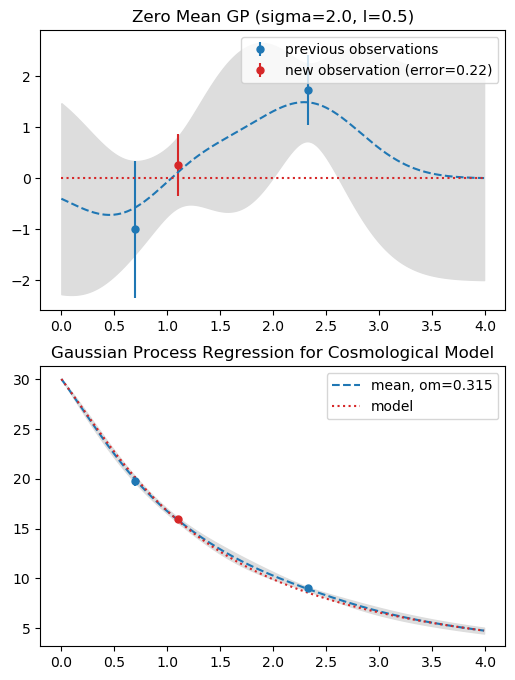

In [20]:
se_l = 0.5 # smoothness parameter
se_sigma = 2.0 # thickness parameter
poly_degree = 1.0 # degree of polynomial kernel
poly_sigma = 2.0

kernels = GP_Kernels(se_sigma=se_sigma, se_l=se_l, poly_sigma=poly_sigma, poly_degree=poly_degree)

kernel = kernels.se_kernel
    
om = torch.tensor([0.315], device=device).reshape(-1, 1) # Gaussian prior mean
sigma_prior = torch.tensor(0.02, device=device) # Gaussian prior std

z_val = round(1.1,2)
new_z = torch.tensor(z_val, device=device)
prev_z = torch.tensor([z_1, z_2], device=device)
X = torch.concat((prev_z, new_z.unsqueeze(0)), dim=0)
X = X.repeat(len(om), 1).unsqueeze(-1) # shape: (batch_size, 2)

new_y = D_H_func(new_z)
prev_y = torch.tensor([y_h1, y_h2], device=device)
measured_y = torch.concat((prev_y, new_y.unsqueeze(0)), dim=0)
zero_y = (2/(sigma_prior*((1+X.squeeze())**3-1)))*((measured_y*(om*(1+X.squeeze())**3+(1-om))**(3/2))/coeff-(om*(1+X.squeeze())**3+(1-om)))

new_error = torch.tensor(D_H_error_func(z_val), device=device).unsqueeze(0)
prev_error = torch.tensor([sig_h1, sig_h2], device=device)
error = torch.concat((prev_error, new_error), dim=0)
zero_error = (2*error*(om*(1+X.squeeze())**3+(1-om))**(3/2))/(coeff*(sigma_prior*((1+X.squeeze())**3-1))) # zero error

K = kernel(X, X) # shape: (N, N)
L = torch.linalg.cholesky(K + zero_error.unsqueeze(-1)*torch.eye(X.shape[1], device=device)) # add zeroed error, (line 1 of https://arxiv.org/pdf/2009.10862.pdf)

# points we're going to make predictions at.
X_test = torch.arange(0, 4, 0.01).to(device) # shape: (M,1), M = number of test points
X_test = X_test.repeat(len(om), 1).unsqueeze(-1)

# compute the mean at our test points.
Lk = torch.linalg.solve(L, kernel(X, X_test))  # k_star = kernel(X, X_test), calculating v := l\k_star (line 4), shape: (batch_size, N, M)
mu = torch.matmul(Lk.transpose(1,2), torch.linalg.solve(L, zero_y.unsqueeze(-1)))    # \alpha = np.linalg.solve(L, y), (lines 2 and 3), shape: (batch_size, M, 1)

# compute the variance at our test points.
K_ = kernel(X_test, X_test)        # k(x_star, x_star)
s2 = torch.diagonal(K_, dim1=1, dim2=2) - torch.sum(Lk**2, axis=1) # s2 = k_star_star - np.einsum("ij,ij->j", v, v) (line 5), shape: (batch_size, M)
s = torch.sqrt(s2)

mean_pred = coeff*(mu.squeeze()*((sigma_prior*((1+X_test.squeeze())**3-1))/(2*(om*(1+X_test.squeeze())**3+(1-om))**(3/2))) + (om*(1+X_test.squeeze())**3+(1-om))**(-1/2))
error_pred = (s*coeff*sigma_prior*((1+X_test.squeeze())**3-1))/(2*(om*(1+X_test.squeeze())**3+(1-om))**(3/2))
fig1, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
colors = ["tab:blue", "tab:orange", "tab:green"]
for i in range(len(om)):
    next_color = colors.pop(0)
    ax1.errorbar(
        X.squeeze(-1)[i,:-1].cpu(),
        zero_y[i,:-1].cpu(),
        zero_error[i,:-1].cpu(),
        linestyle="None",
        color=next_color,
        marker=".",
        markersize=10,
        label="previous observations"
    )
    ax1.errorbar(
        X[i,-1].cpu(),
        zero_y[i,-1].cpu(),
        zero_error[i,-1].cpu(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=10,
        label=f"new observation (error={new_error.squeeze().item():.2f})",
    )
    ax1.plot(X_test[i].cpu(), mu[i].cpu(), linestyle='--', color=next_color)
    ax1.fill_between(
        X_test[i].squeeze().cpu(),
        mu[i].squeeze().cpu() - s[i].squeeze().cpu(),
        mu[i].squeeze().cpu() + s[i].squeeze().cpu(),
        color="#dddddd",
    )
ax1.plot(X_test[i].cpu(), torch.zeros(len(X_test[i])).cpu(), linestyle=':', color="tab:red")
ax1.legend()
ax1.set_title(f'Zero Mean GP (sigma={se_sigma}, l={se_l})')
colors = ["tab:blue", "tab:orange", "tab:green"]
for i in range(len(om)):
    next_color = colors.pop(0)
    ax2.errorbar(
        X.squeeze(-1)[i,:-1].cpu(),
        measured_y[:-1].cpu(),
        error[:-1].cpu(),
        linestyle="None",
        color=next_color,
        marker=".",
        markersize=10,
    )
    ax2.errorbar(
        X[i][-1].cpu(),
        measured_y[-1].cpu(),
        error[-1].cpu(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=10,
    )
    ax2.plot(X_test[i].cpu(), mean_pred[i].cpu(), linestyle='--', color=next_color, label=f'mean, om={om[i].item()}')
    ax2.fill_between(
        X_test[i].squeeze().cpu(),
        mean_pred[i].squeeze().cpu() - error_pred[i].squeeze().cpu(),
        mean_pred[i].squeeze().cpu() + error_pred[i].squeeze().cpu(),
        color="#dddddd",
    )
ax2.plot(X_test[i].cpu(), coeff/torch.sqrt(om[0].cpu()*(1+X_test[i].cpu())**3+(1-om[0].cpu())), linestyle=':', color="tab:red", label=f'model')
ax2.set_title('Gaussian Process Regression for Cosmological Model')
ax2.legend()
plt.show()

In [18]:
class GPRegressionModel:
    def __init__(self, omm_prior, omm_sigma_prior, kernel, kind):
        self.omm_prior = torch.tensor(omm_prior, device=device)
        self.omm_sigma_prior = torch.tensor(omm_sigma_prior, device=device)
        #self.measurement_error = measurement_error
        self.kernel = kernel
        self.D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind=kind)

    def gp_func(self, om, designs, sigma_prior):
        om_shape = om.shape
        #om = om.reshape(-1, 1)
        design_pt_error = []
        for i, d in enumerate(designs[0]):
            om_d = om[:,i] # (n_particles, 1)
            z_val = round(d.item(),2)
            new_z = torch.tensor(z_val, device=device)
            prev_z = torch.tensor([z_1, z_2], device=device)
            X = torch.concat((prev_z, new_z.unsqueeze(0)), dim=0)
            X = X.repeat(len(om), 1).unsqueeze(-1) # shape: (batch_size, 2)

            new_y = D_H_func(new_z, om_d)
            prev_y = torch.tensor([y_h1, y_h2], device=device)
            prev_y = prev_y.repeat(len(om_d), 1)
            measured_y = torch.concat((prev_y, new_y), dim=-1)
            zero_y = (2/(sigma_prior*((1+X.squeeze())**3-1)))*((measured_y*(om_d*(1+X.squeeze())**3+(1-om_d))**(3/2))/coeff-(om_d*(1+X.squeeze())**3+(1-om_d)))

            #new_error = torch.tensor(self.measurement_error, device=device).unsqueeze(-1)
            new_error = torch.tensor(self.D_H_error_func(z_val), device=device).unsqueeze(0)
            prev_error = torch.tensor([sig_h1, sig_h2], device=device)
            error = torch.concat((prev_error, new_error), dim=0)
            zero_error = (2*error*(om_d*(1+X.squeeze())**3+(1-om_d))**(3/2))/(coeff*(sigma_prior*((1+X.squeeze())**3-1))) # zero error


            K = self.kernel(X, X) # shape: (N, N)
            L = torch.linalg.cholesky(K + zero_error.unsqueeze(-1)*torch.eye(X.shape[1]).to(device)) # add error, (line 1 of https://arxiv.org/pdf/2009.10862.pdf)

            # points we're going to make predictions at.
            X_test = torch.arange(0.05, 5, 0.05).to(device) # shape: (M,1), M = number of test points
            X_test = X_test.repeat(len(om_d), 1).unsqueeze(-1)

            # compute the mean at our test points.
            Lk = torch.linalg.solve(L, self.kernel(X, X_test))  # k_star = kernel(X, X_test), calculating v := l\k_star (line 4), shape: (batch_size, N, M)
            mu = torch.matmul(Lk.transpose(1,2), torch.linalg.solve(L, zero_y.unsqueeze(-1)))    # \alpha = np.linalg.solve(L, y), (lines 2 and 3), shape: (batch_size, M, 1)

            # compute the variance at our test points.
            K_ = self.kernel(X_test, X_test) # k(x_star, x_star)
            s2 = torch.diagonal(K_, dim1=1, dim2=2) - torch.sum(Lk**2, axis=1) # s2 = k_star_star - np.einsum("ij,ij->j", v, v) (line 5), shape: (batch_size, M)
            s = torch.sqrt(s2)

            # rescale the mean and variance
            mean_pred = coeff*(mu.squeeze()*((sigma_prior*((1+X_test.squeeze())**3-1))/(2*(om_d*(1+X_test.squeeze())**3+(1-om_d))**(3/2))) + (om_d*(1+X_test.squeeze())**3+(1-om_d))**(-1/2))
            error_pred = s*sigma_prior*(coeff*((1+X_test.squeeze())**3-1))/(2*(om_d*(1+X_test.squeeze())**3+(1-om_d))**(3/2))
            
            # find the error at the new design point
            design_pt_error.append(error_pred[:,X_test[0].cpu().squeeze().numpy().round(2).tolist().index(z_val)])
        
        design_pt_errors = torch.stack(design_pt_error)
        # rearrange dimensions of design_pt_errors to match the shape of om
        output = design_pt_errors.transpose(0,1).unsqueeze(-1)
        return output

    def model(self, designs):
        with pyro.plate_stack("plate", designs.shape[:-1]):
            om_m = pyro.sample("om_m", dist.Normal(self.omm_prior, self.omm_sigma_prior)).unsqueeze(-1) # shape: [n,num_designs,1]
            y_pred = coeff/torch.sqrt(om_m*(1+designs)**3+(1-om_m)) # shape: [n, num_designs, 1]
            self.y_sigma = self.gp_func(om_m, designs, self.omm_sigma_prior) # shape: [n, num_designs, 1]
            return pyro.sample("y", dist.Normal(y_pred, self.y_sigma).to_event(1))

    def y_sigma(self):
        return self.y_sigma

step: 0, loss: 143.7885175381504
step: 20000, loss: -125.18530317832469
step: 40000, loss: -124.99724393783052


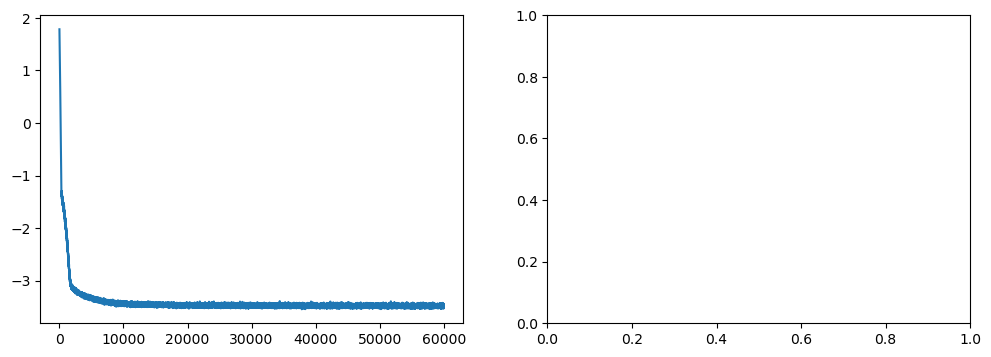

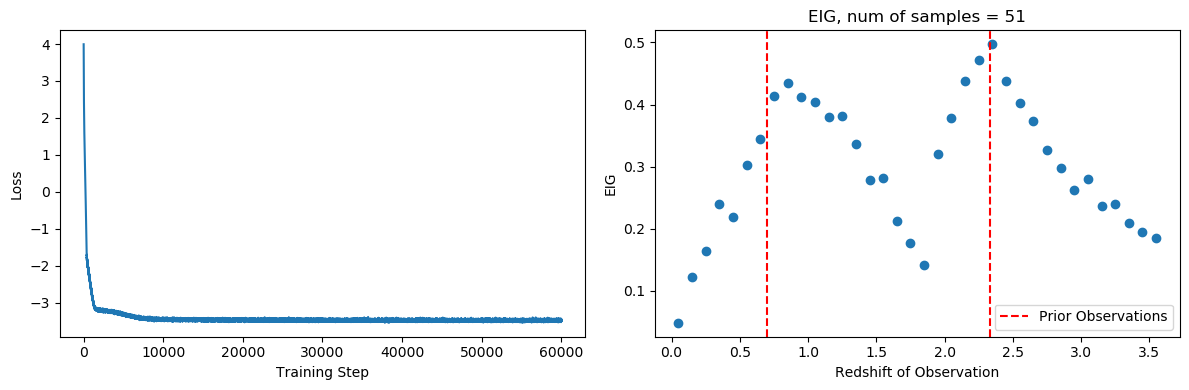

In [19]:
se_l = 0.5 # smoothness parameter
se_sigma = 2.0 # thickness parameter
kernel = GP_Kernels(se_sigma=se_sigma, se_l=se_l).se_kernel
GPR_model = GPRegressionModel(0.315, 0.01, kernel, "linear")

train_args = {"observation_labels": ["y"],
            "target_labels": ["om_m"],
            "model": GPR_model.model,
            "steps": 60000,
            "n_particles": 51,
            "train_verbose": True, 
            "condition_design": True,
            "device": device}

posterior_flow = flows.conditional_affine_autoregressive(num_transforms, flow_args=flow_args)

pyro.clear_param_store()
optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=5e-5)
device = train_args["device"]
posterior_flow.to(device)
posterior_flow.train(mode=True)
pyro.set_rng_seed(0)
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
history = []
for step in range(train_args["steps"]):
    optimizer.zero_grad()
    agg_loss, loss = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=train_args["n_particles"],
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=False,
                                    nflow=True,
                                    condition_design=train_args["condition_design"])
    agg_loss.backward()
    optimizer.step()
    if step == 0:
        verbose_shapes = False

    history.append(loss)
    if train_args["train_verbose"] and (step % 20000 == 0):
        print('step: {}, loss: {}'.format(step, agg_loss.item()))

stacked_history = torch.stack(history)
history_array = stacked_history.cpu().detach().numpy()

# plot a log scale so small changes in the beginning are visible
ax1.plot(torch.mean(stacked_history, axis=1).cpu().detach().numpy())

y_sigmas = GPR_model.y_sigma.mean(axis=0).squeeze().cpu().detach().numpy()

with torch.no_grad():
    agg_loss, eigs = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=2000,
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=True,
                                    nflow=True,
                                    condition_design=train_args["condition_design"])
                                    
ax2.plot(redshifts, eigs.cpu().detach().numpy(), 'o')
# plot vertical line of the previous measurements
ax2.axvline(x=z_1, color='r', linestyle='--', label="Prior Observations")
ax2.axvline(x=z_2, color='r', linestyle='--')
# add subplot title
ax2.set_title('EIG, num of samples = {}'.format(train_args["n_particles"]))

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")

ax2.set_xlabel("Redshift of Observation")
ax2.set_ylabel("EIG")

ax2.legend()
plt.tight_layout()
plt.show()

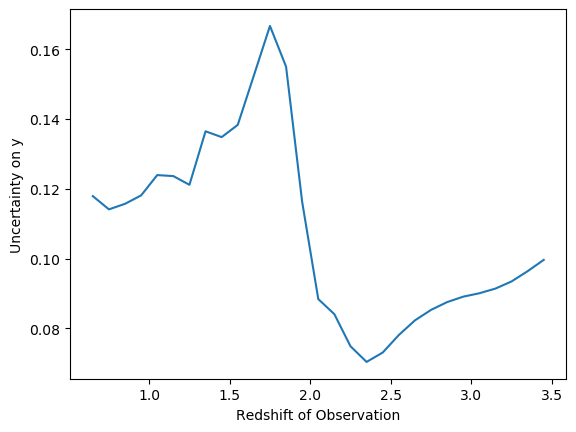

In [124]:
plt.figure()
plt.plot(designs.cpu().detach().numpy(), GPR_model.sigma.mean(axis=0).squeeze().cpu().detach().numpy())
plt.xlabel("Redshift of Observation")
plt.ylabel("Uncertainty on y")
plt.show()